In [1]:
from __future__ import absolute_import, division, print_function

In [2]:
import os
import json
import pandas as pd
import glob
import numpy as np
import sys
import time
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.neighbors.kde import KernelDensity
from collections import Counter

## Python packages - you may have to pip install sqlalchemy, sqlalchemy_utils, and psycopg2.
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

%matplotlib inline


# Define function to find local maxima in array

In [3]:
def find_local_max(inarr,win=3,style='mode',level=3,**kwargs):
    """
    Find the local maxima in an array.
    
    The input array should be a (NxN) numpy array.
    
    A window of size (win)x(win) is used.
    Window size win needs to be an odd number
    to have a defined center pixel. If win is even, 
    it is autamtically increased by +1.
    
    The output is a mask of size equal to the input array 
    (NxN) with 0, unless a pixel is identified as a maximum.
    
    The maxima are evaluated base on 'style' using 'level'. 
    E.g., for 'style=mode' and 'level=3', a local maximum if 
    found is retained if its value is 3 times the mode of the
    image.
    """
    # check input
    if win%2 == 0:
        win += 1
    # create empty mask
    shp = inarr.shape
    mask = np.zeros(shape=shp)
    # central index of window
    win_idx = int(np.floor(win/2.)) 
    cen_idx = (win_idx,win_idx)
    win_mask = np.zeros(shape=(win,win))
    win_mask[cen_idx] = 1
    comp_mask = win_mask == 0
    val_mask = win_mask == 1
    xlen = len(inarr[:,0])
    ylen = len(inarr[:,1])
    # determine more in array
    inarr_ravel = inarr.ravel()
    tmp_list = np.ndarray.tolist(inarr_ravel)
    if style == 'mean':
        tmp_mode = np.mean(inarr_ravel)
        print('Using MEAN for cutoff: ', tmp_mode)
    elif style == 'median':
        tmp_mode = np.median(inarr_ravel)
        print('Using MEDIAN for cutoff: ', tmp_mode)
    elif style == 'bkg':
        tmp_mode = find_background(inarr,**kwargs)
        print('Using BKG for cutoff: ', tmp_mode)
    else:
        tmp_mode = Counter(tmp_list).most_common(1)[0][0]
        print('Using MODE for cutoff: ', tmp_mode)
    cutoff = level*tmp_mode
    for xidx,xin in enumerate(inarr[:,0]):
        for yidx,yin in enumerate(inarr[0,:]):
            sub_arr = inarr[xidx-win_idx:xidx+win_idx+1,yidx-win_idx:yidx+win_idx+1]
            if sub_arr.shape != (win,win):
                pass
            else:
                comp_vals = sub_arr[comp_mask]
                mid_val = sub_arr[val_mask]
                check = [False if x < mid_val else True for x in comp_vals]
                if (sum(check) == 0) and (mid_val > cutoff):
                    mask[xidx,yidx] = int(1)
    final_mask = mask == 1
    return final_mask
        

# Define function to find background in array

In [4]:
def find_background(inarr,patch=3,method='median',n_samples=50):
    """
    Find the background value in a 2D array.
    
    Randomly sample the array at 'n_samples' locations. Take 
    metric as set by 'style' within square region with side length 
    defined by 'win'. 
    
    Returns background value of array.
    """
    xdim = inarr.shape[0]
    ydim = inarr.shape[1]
    xidx = np.random.randint(0,xdim-1,n_samples)
    yidx = np.random.randint(0,ydim-1,n_samples)
    coords = zip(xidx,yidx)
    bkg_vec = []
    for idx,coord in enumerate(coords):
        tmp_patch = inarr[coord[0]-patch:coord[0]+patch,coord[1]-patch:coord[1]+patch]
        try:
            if method == 'mean':
                tmp_val = np.mean(tmp_patch)
            else:
                tmp_val = np.median(tmp_patch)
            bkg_vec.append(tmp_val)
        except:
            pass
    if method == 'mean':
        return np.nanmean(bkg_vec)
    else:
        return np.nanmedian(bkg_vec)
            
    

    
    
    
    

# Get coordinates for CA state

In [5]:
# Get CA coordinates
infile = os.path.join('..','..','data','ca_shape.csv')
ca_shape = pd.read_csv(infile)
x_coords = ca_shape['longitude'].tolist()
y_coords = ca_shape['latitude'].tolist()


# Get main data (cleaned and complete) from pickle

In [6]:
# import pre-selected and pickled dataframe
start_time = time.time()
flickr_all_clean = pd.read_pickle(os.path.join('..','..','data','flickr_all_clean.df'))
print("--- %s seconds ---" % (time.time() - start_time))


--- 26.2465958595 seconds ---


# Select subset of data

In [7]:
keyword = 'dog'
#keyword = 'skateboard'
#keyword = 'toyota'

In [8]:
# Select subset based on keyword
start_time = time.time()
df = flickr_all_clean[flickr_all_clean['title_tags']
                                         .str.contains(keyword, na=False)]
print("--- %s seconds ---" % (time.time() - start_time))
print(df.shape)

--- 3.44482302666 seconds ---
(35462, 8)


# Select based on longitude / latitude range

In [9]:
# Extract long/lat and combine into 2d array
limit_lng = [-122.4,-122]
limit_lat = [37.4,37.7]
#
limit_lng = [-122.7,-121.8]
limit_lat = [36.7,38.3]
#
#limit_lat = []
#
if len(limit_lng) != 0 and len(limit_lat) != 0:
    yin = np.array((df['longitude'][(df['longitude'] > limit_lng[0]) & 
                                    (df['longitude'] < limit_lng[1]) & 
                                    (df['latitude'] > limit_lat[0]) & 
                                    (df['latitude'] < limit_lat[1])].tolist()))

    xin = np.array((df['latitude'][(df['longitude'] > limit_lng[0]) & 
                                   (df['longitude'] < limit_lng[1]) & 
                                   (df['latitude'] > limit_lat[0]) & 
                                   (df['latitude'] < limit_lat[1])].tolist()))
else:
    yin = np.array((df['longitude'][(df['longitude'] != 0.0) & (df['latitude'] != 0.0)].tolist()))
    xin = np.array((df['latitude'][(df['longitude'] != 0.0) & (df['latitude'] != 0.0)].tolist()))
XY = np.vstack([yin.ravel(), xin.ravel()]).T

# Run KDE

In [10]:
lng_max = max(yin)
lng_min = min(yin)
lat_max = max(xin)
lat_min = min(xin)
# Set up the data grid for the contour plot
xgrid = np.linspace(lng_min,lng_max,100)
ygrid = np.linspace(lat_min,lat_max,100)
X, Y = np.meshgrid(xgrid, ygrid)
#
xy = np.vstack([Y.ravel(), X.ravel()]).T
xy *= np.pi / 180.
#
Xtrain = np.vstack([xin,yin]).T
Xtrain *= np.pi / 180.  # Convert lat/long to radians
#
kde = KernelDensity(bandwidth=0.0003)
kde.fit(Xtrain)
#
Z = np.exp(kde.score_samples(xy))
Z = Z.reshape(X.shape)

# Find local maxima in KDE estimates

In [11]:
local_maxima_map = find_local_max(np.sqrt(Z),win=7,style='bkg', 
                                  level=3,patch=5,method='mean',
                                  n_samples=50)
xy_maxima = np.array((X.reshape(local_maxima_map.shape)[local_maxima_map],
                      Y.reshape(local_maxima_map.shape)[local_maxima_map])).T



/usr/local/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


Using BKG for cutoff:  28.6711744538


# Plot results

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
(8698,)


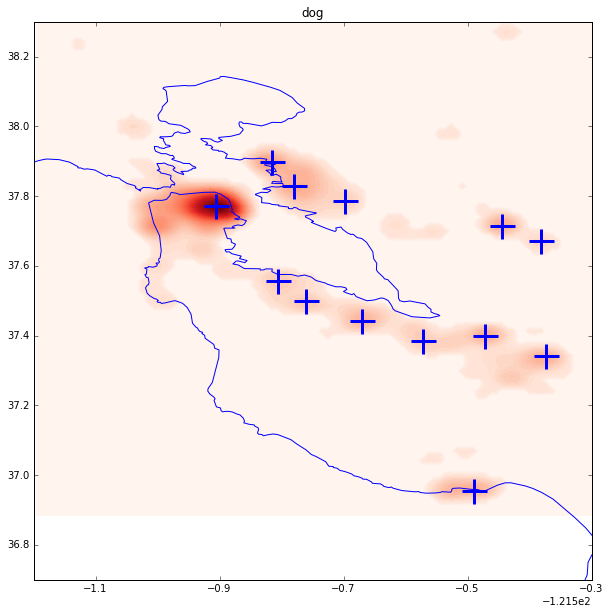

In [107]:
# create figure
plt.figure(figsize=(10,10))
# plot CA outline
plt.plot(x_coords,y_coords)
#  plot contours of the density
Z_mask = Z < 29**2.*3
Z_new = Z
Z_new[Z_mask] = 0
print(Z_new)
print(X[Z_mask].shape)
levels = np.linspace(0, np.log10(Z_new.max()), 50)
levels = np.linspace(0, np.sqrt(Z_new.max()), 50)
plt.contourf(X, Y, np.sqrt(Z_new), levels=levels, cmap=plt.cm.Reds)
#
plt.plot(xy_maxima[:, 0], xy_maxima[:, 1],'+', 
         markersize=25,markeredgewidth=3,markeredgecolor='b')
#
if len(limit_lng) != 0 and len(limit_lat) != 0:
    plt.xlim(limit_lng[0],limit_lng[1])
    plt.ylim(limit_lat[0],limit_lat[1]) 
else:
    plt.xlim(-123,-121.5)
    plt.ylim(36.7,38.5) 
plt.title(keyword)
#
plt.show()

In [14]:
deriv = np.gradient(Z)

In [24]:
print(deriv[0].shape)

(100, 100)


In [87]:
deriv_all = deriv[0] #+ np.abs(deriv[1])
print(deriv_all.shape)

(100, 100)


[96 93 90 90 91 92 92 92 91 89 88 89 92 91 92 91 82 80 80 78 79 83 83 81 75
 71 71 76 74 72 74 74 76 81 82 82 83 81 83 81 77 75 76 75 76 78 80 77 76 77
 72 69 68 72 70 69 69 70 75 76 80 79 76 76 73 71 72 72 67 64 64 64 65 62 62
 63 66 64 64 64 64 63 68 72 72 72 74 71 72 74 77 78 78 85 80 80 84 83 83 85]


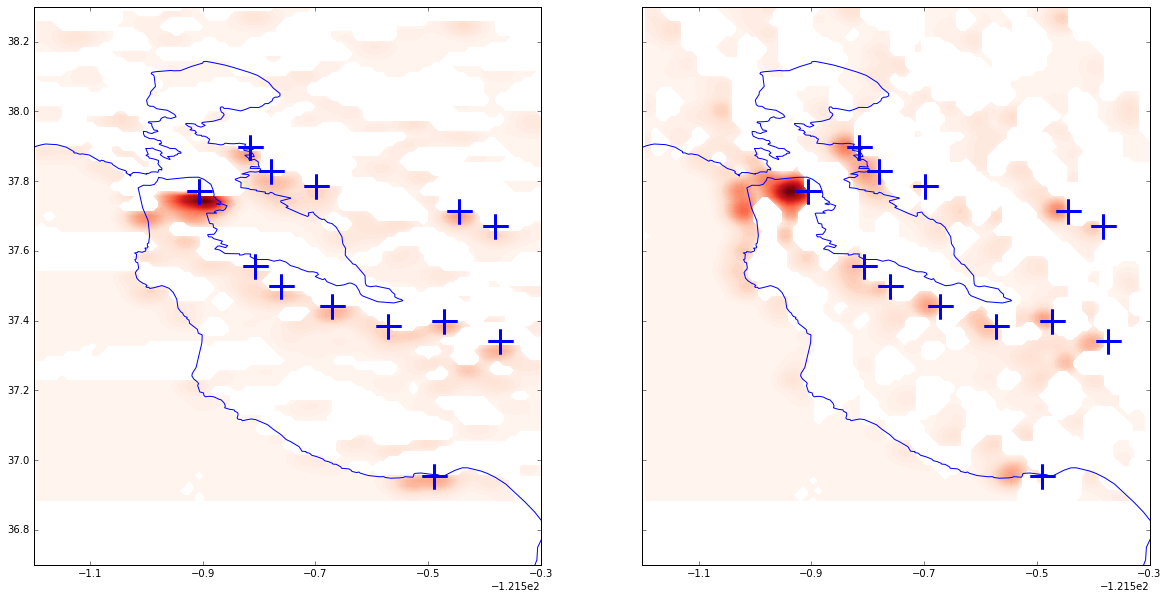

In [91]:
#plt.figure(figsize=(10,10))
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,sharex=True,figsize=(20,10))
ax1.plot(x_coords,y_coords)
ax2.plot(x_coords,y_coords)
plt.xlim(limit_lng[0],limit_lng[1])
plt.ylim(limit_lat[0],limit_lat[1]) 

xy_maxima = np.array((X.reshape(local_maxima_map.shape)[local_maxima_map],
                      Y.reshape(local_maxima_map.shape)[local_maxima_map])).T
#
levels = np.linspace(0, np.sqrt(deriv[0].max()), 50)
ax1.contourf(X, Y, np.sqrt(deriv[0]), levels=levels, cmap=plt.cm.Reds)
ax1.plot(xy_maxima[:, 0], xy_maxima[:, 1],'+', 
         markersize=25,markeredgewidth=3,markeredgecolor='b')
#
levels = np.linspace(0, np.sqrt(deriv[1].max()), 50)
ax2.contourf(X, Y, np.sqrt(deriv[1]), levels=levels, cmap=plt.cm.Reds)
ax2.plot(xy_maxima[:, 0], xy_maxima[:, 1],'+', 
         markersize=25,markeredgewidth=3,markeredgecolor='b')





grad_mask = deriv_all < 29.*3 

print(sum(grad_mask))

ax1.plot(xy_maxima[:, 0], xy_maxima[:, 1],'+', 
         markersize=25,markeredgewidth=3,markeredgecolor='b')
ax2.plot(xy_maxima[:, 0], xy_maxima[:, 1],'+', 
         markersize=25,markeredgewidth=3,markeredgecolor='b')
plt.show()


In [95]:
# Normalize Z
Z_mask = Z < 29.*3
norm=np.linalg.norm(Z[Z_mask])
Z_norm = Z/norm
Z_norm[Z_mask] = 0
print(Z_norm)

[[ 0.          0.          0.         ...,  0.25196174  0.16460762
   0.08232035]
 [ 0.          0.          0.         ...,  0.19828783  0.12428484
   0.06067761]
 [ 0.          0.          0.         ...,  0.09611018  0.05321121  0.        ]
 ..., 
 [ 0.11867741  0.22163704  0.34157318 ...,  0.          0.          0.        ]
 [ 0.08163012  0.15116193  0.22854558 ...,  0.          0.          0.        ]
 [ 0.          0.05455572  0.08146906 ...,  0.          0.          0.        ]]


In [ ]:
# Run through every pixel in map
# If pixel value on KDE map below threshold, ignore
# Else, determine distance to each cluster center.
# Assign pixel to cluster center it's closes to (simple eucleidan here)

In [244]:
# xy_maxima = np.array((X.reshape(local_maxima_map.shape)[local_maxima_map],
#                       Y.reshape(local_maxima_map.shape)[local_maxima_map])).T

# xy_maxima[:, 0], xy_maxima[:, 1]

# peak_pos = np.array()

base_coords_map = np.array((X.reshape(local_maxima_map.shape),
                            Y.reshape(local_maxima_map.shape))).T


def integrate_peaks(inarr,peaks,threshold):
    mask = np.zeros(inarr.shape)
    for xidx,xin in enumerate(inarr[:,0]):
        for yidx,yin in enumerate(inarr[0,:]):
            value = inarr[xidx,yidx]
            if value <= threshold:
                pass
            else:
                dist = []
                for idx,peak in enumerate(peaks):
                    label = idx+1
                    pix_coord = base_coords_map[xidx,yidx]
                    dist.append(np.linalg.norm(peak-pix_coord))
                # find minimum index in list
                min_val = min(dist)
                idx_min = [tmp_idx for tmp_idx,x in enumerate(dist) if x == min_val]
                # replace elemnt in mask with label
                mask[xidx,yidx] = idx_min[0]+1
    return mask
        
        


In [249]:
peaks_mask = integrate_peaks(Z,xy_maxima,cutoff)  
plt.imshow(peaks_mask,origin='lower')

NameError: name 'cutoff' is not defined

In [248]:
print(set(peaks_mask))

TypeError: unhashable type: 'numpy.ndarray'

In [236]:
# int_maxinma = np.array((X.reshape(local_maxima_map.shape)[local_maxima_map],
#                         Y.reshape(local_maxima_map.shape)[local_maxima_map])).T

base_coords_map = np.array((X.reshape(local_maxima_map.shape),
                            Y.reshape(local_maxima_map.shape))).T
print(base_coords_map[0,0])

[-122.694757   36.884138]


In [ ]:
    for xidx,xin in enumerate(inarr[:,0]):
        for yidx,yin in enumerate(inarr[0,:]):
            sub_arr = inarr[xidx-win_idx:xidx+win_idx+1,yidx-win_idx:yidx+win_idx+1]
            if sub_arr.shape != (win,win):
                pass
            else:
                comp_vals = sub_arr[comp_mask]
                mid_val = sub_arr[val_mask]
                check = [False if x < mid_val else True for x in comp_vals]
                if (sum(check) == 0) and (mid_val > cutoff):
                    mask[xidx,yidx] = int(1)


In [ ]:
def create_cluster_map(inarr,background):
    # normalize 
    mask = inarr > background
    min_val = inarr[mask].min()
    inarr_rescale = inarr / min_val
    inarr_rescale[~mask] = 0
    xout = []
    yout = []
    for xidx,xin in enumerate(inarr_rescale[:,0]):
        for yidx,yin in enumerate(inarr_rescale[0,:]):
            scale = np.round(inarr_rescale[xidx,yidx])
            if scale > 0.0:
                for num in range(int(scale)):
                    xout.append(xidx)
                    yout.append(yidx)
    xlen = len(xout)
    xnoise = np.random.normal(-0.1,0.1,xlen)
    ynoise = np.random.normal(-0.1,0.1,xlen)
    xout = [sum(x) for x in zip(xout, xnoise)]
    yout = [sum(x) for x in zip(yout, ynoise)]
    out_data = zip(xout,yout)
    return out_data

In [216]:
def create_cluster_map(inarr,background):
    # normalize 
    mask = inarr > background
    min_val = inarr[mask].min()
    inarr_rescale = inarr / min_val
    inarr_rescale[~mask] = 0
    xout = []
    yout = []
    for xidx,xin in enumerate(inarr_rescale[:,0]):
        for yidx,yin in enumerate(inarr_rescale[0,:]):
            scale = np.round(inarr_rescale[xidx,yidx])
            if scale > 0.0:
                for num in range(int(scale)):
                    xout.append(xidx)
                    yout.append(yidx)
    xlen = len(xout)
    xnoise = np.random.normal(-0.1,0.1,xlen)
    ynoise = np.random.normal(-0.1,0.1,xlen)
    xout = [sum(x) for x in zip(xout, xnoise)]
    yout = [sum(x) for x in zip(yout, ynoise)]
    out_data = zip(yout,xout)
    return out_data

In [219]:
out = np.array(create_cluster_map(Z,4000))
print(out.shape)

(5274, 2)


Estimated number of clusters: 16


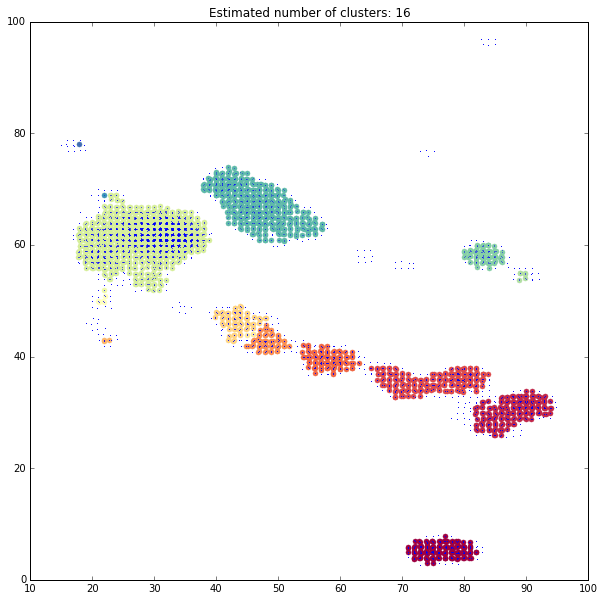

In [222]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
# Compute DBSCAN
db = DBSCAN(eps=1.0,algorithm='ball_tree',min_samples=5).fit(out)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
# # Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)# Plot result
plt.figure(figsize=(10,10))

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'


    plt.plot(out[:, 0], out[:, 1], 'o', markerfacecolor='none', 
             markeredgecolor='b', markersize=0.1)

    class_member_mask = (labels == k)
    xy = out[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor=col, markersize=5)


plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()


Estimated number of clusters: 13
[ 3  3  3 ..., 12 12 12]


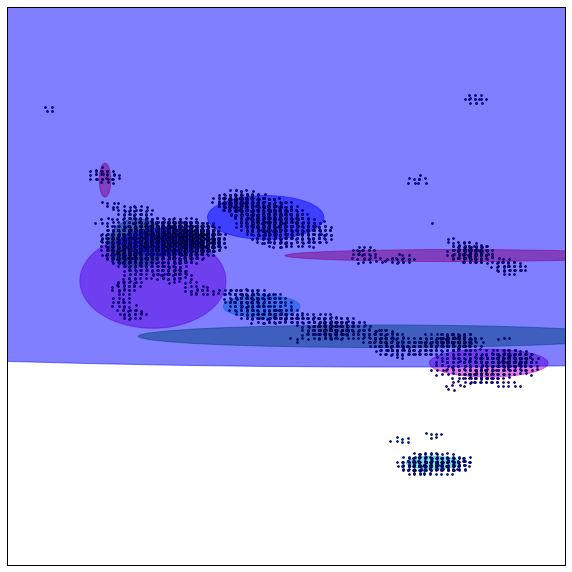

In [212]:
from sklearn import mixture
import itertools
from scipy import linalg
# Fit a Dirichlet process mixture of Gaussians using five components
plt.figure(figsize=(10,10))
plt.plot(out[:, 0], out[:, 1], 'o', markerfacecolor=None,
             markeredgecolor='k', markersize=2)

color_iter = itertools.cycle(['r', 'g', 'b', 'c', 'm'])

dpgmm = mixture.GMM(n_components=13,n_iter=100)
dpgmm.fit(out)
Y_ = dpgmm.predict(out)
n_clusters_ = len(set(Y_)) - (1 if -1 in Y_ else 0)
print('Estimated number of clusters: %d' % n_clusters_)

print(Y_)
for i, (mean, covar, color) in enumerate(zip(
        dpgmm.means_, dpgmm._get_covars(), color_iter)):
    splot = plt.subplot(1, 1, 1)
    v, w = linalg.eigh(covar)
    u = w[0] / linalg.norm(w[0])
    # as the DP will not use every component it has access to
    # unless it needs it, we shouldn't plot the redundant
    # components.
    if not np.any(Y_ == i):
        continue
    plt.scatter(out[Y_ == i, 0], out[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=color)
    ell.set_alpha(0.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())

plt.show()


In [201]:
print(xy[:, 0], xy[:, 1])

[] []


In [65]:
import numpy as np
import scipy.ndimage.filters as filters
import scipy.ndimage.morphology as morphology

def detect_local_minima(arr):
    # http://stackoverflow.com/questions/3684484/peak-detection-in-a-2d-array/3689710#3689710
    """
    Takes an array and detects the troughs using the local maximum filter.
    Returns a boolean mask of the troughs (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """
    # define an connected neighborhood
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#generate_binary_structure
    neighborhood = morphology.generate_binary_structure(len(arr.shape),1)
    # apply the local minimum filter; all locations of minimum value 
    # in their neighborhood are set to 1
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.filters.html#minimum_filter
    local_min = (filters.minimum_filter(arr, footprint=neighborhood)==arr)
    # local_min is a mask that contains the peaks we are 
    # looking for, but also the background.
    # In order to isolate the peaks we must remove the background from the mask.
    # 
    # we create the mask of the background
    background = (arr < 100)
    # 
    # a little technicality: we must erode the background in order to 
    # successfully subtract it from local_min, otherwise a line will 
    # appear along the background border (artifact of the local minimum filter)
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#binary_erosion
    eroded_background = morphology.binary_erosion(
        background, structure=neighborhood, border_value=1)
    # 
    # we obtain the final mask, containing only peaks, 
    # by removing the background from the local_min mask
    detected_minima = local_min - eroded_background
    return np.where(detected_minima)       

In [66]:
local_minima_locations = detect_local_minima(Z)


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:35: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


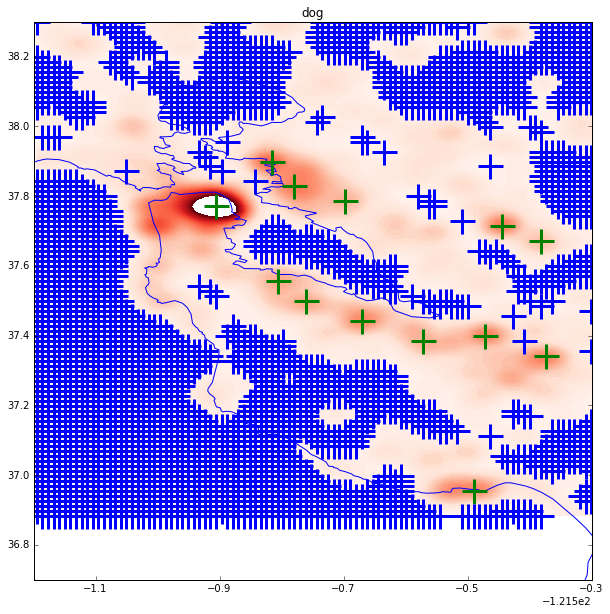

In [67]:
# create figure
plt.figure(figsize=(10,10))
# plot CA outline
plt.plot(x_coords,y_coords)
#  plot contours of the density
levels = np.linspace(0, np.log10(Z.max()), 50)
levels = np.linspace(0, np.sqrt(Z.max())-np.sqrt(Z.max())/3, 50)
plt.contourf(X, Y, np.sqrt(Z), levels=levels, cmap=plt.cm.Reds)
#
plt.plot(xy_maxima[:, 0], xy_maxima[:, 1],'+', 
         markersize=25,markeredgewidth=3,markeredgecolor='g')
#
plt.plot(X[local_minima_locations], Y[local_minima_locations],'+', 
         markersize=25,markeredgewidth=3,markeredgecolor='b')
if len(limit_lng) != 0 and len(limit_lat) != 0:
    plt.xlim(limit_lng[0],limit_lng[1])
    plt.ylim(limit_lat[0],limit_lat[1]) 
else:
    plt.xlim(-123,-121.5)
    plt.ylim(36.7,38.5) 
plt.title(keyword)
#
plt.show()

In [70]:
out = np.ptp(Z)
print(out)

327847.506153


In [69]:
print(out.shape)

()
